# DSCI100 Final Group Project

## Introduction

Unlike previous years, this year's data science final project is a real world project with real stakeholders. A group in CS at UBC is interested in understanding how people play video games. They've set up a server running Minecraft and are recording data in 2 .csv files called "players.csv" and "sessions.csv". Running the server is not easy: you need to have the right hardware resources, software licenses, recruiting efforts, etc. To optimize their performance, they need to answer some questions. In this project, our group is answering the question of "During what time of day are most likely to have large number of simultaneous players"?

## Data Description:

The datasets given are these two files: players.csv and sessions.csv.

players.csv contains 197 observations of:
+ experience: Player’s chosen experience level, such as Pro, Veteran, Amateur, etc.
+ subscribe: Indicates if the player has subscribed to the email notification (True/False).
+ played_hours: Total hours played by the player.
+ gender: Gender of the player.
+ age: Age of the player.

sessions.csv contains 1536 observations of:
+ hashedEmail: Anonymized identifier linking sessions to players.
+ start_time and end_time: Start and end times of each play session.
+ original_start_time and original_end_time: Timestamps for each session's start and end.

We plan to combine the information given from both files to calculate player metrics like session frequency, average session length, total playtime and time of day or day of week patterns. There is missing data in players.csv (individualId, organizationName) and there are outliers and inconsistencies in session.csv which will be addressed through data preprocessing, like standardizing the time formats.

## Question: "What time windows are most likely to have large number of simultaneous players?"

The goal is to predict the time window when the demand for concurrent player licenses is based on past patterns. We can analyze the hour of the day as well as the day of the week that most players get on, to help forecast player demand in each time window. This can help the research team manage the licenses and server capacity effectively during peak hours.

The predictors are:

Hour of the day, Day of the week, Weekend or Weekday

Reasoning of choice:

+ The hour of the day reflects daily variations in player activity

+ The day of the week accounts for longer-term fluctuations between weekdays and weekends.

+ The weekend or weekday binary factor provides a simplified but powerful way to segment the data based on user routines, particularly given the significant difference in engagement levels between weekends and weekdays.



We will standardize all the time variables so that it can be easily plotted and analyzed.


## Exploratory Data Analysis and Visualization

To gain insight into player demand patterns, we’ll:

Aggregate data to determine the number of simultaneous players for each hourly window.
Visualize how player counts vary by hour of the day and day of the week.


In [2]:
library(tidyverse)

players_url <- "https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz"
sessions_url <- "https://drive.google.com/uc?export=download&id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB"
download.file(players_url, destfile = "players.csv", mode = "wb")
download.file(sessions_url, destfile = "sessions.csv", mode = "wb")

players <- read_csv("players.csv")
sessions <- read_csv("sessions.csv")

head(players)
head(sessions)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ─────────────────────────────────

experience,subscribe,hashedEmail,played_hours,name,gender,age,individualId,organizationName
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<lgl>,<lgl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,NA,NA
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,NA,NA
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,NA,NA
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,NA,NA
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,NA,NA
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17,NA,NA


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12


In [3]:
#format data to date month year hour minute
merged_data <- sessions %>%
  mutate(
    start_datetime = as.POSIXct(start_time, format = "%d/%m/%Y %H:%M"),
    end_datetime = as.POSIXct(end_time, format = "%d/%m/%Y %H:%M")
  )
head(merged_data)
#make new df to show time windows
#standardaize start times to within the same hour
#count simul players during said time
time_windows <- merged_data %>%
  mutate(hour = format(start_datetime, "%Y-%m-%d %H:00:00")) %>%
  group_by(hour) %>%
  summarise(simultaneous_players = n())
head(time_windows)

#convert back to time format for plotting
time_windows <- time_windows %>%
  mutate(hour = as.POSIXct(hour, format = "%Y-%m-%d %H:%M:%S"))
head(time_windows)

hashedEmail,start_time,end_time,original_start_time,original_end_time,start_datetime,end_datetime
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dttm>,<dttm>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12,2024-06-30 18:12:00,2024-06-30 18:24:00
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12,2024-06-17 23:33:00,2024-06-17 23:46:00
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12,2024-07-25 17:34:00,2024-07-25 17:57:00
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12,2024-07-25 03:22:00,2024-07-25 03:58:00
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12,2024-05-25 16:01:00,2024-05-25 16:12:00
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12,2024-06-23 15:08:00,2024-06-23 17:10:00


hour,simultaneous_players
<chr>,<int>
2024-04-06 09:00:00,2
2024-04-06 20:00:00,1
2024-04-06 22:00:00,1
2024-04-07 00:00:00,1
2024-04-07 02:00:00,1
2024-04-07 05:00:00,2


hour,simultaneous_players
<dttm>,<int>
2024-04-06 09:00:00,2
2024-04-06 20:00:00,1
2024-04-06 22:00:00,1
2024-04-07 00:00:00,1
2024-04-07 02:00:00,1
2024-04-07 05:00:00,2


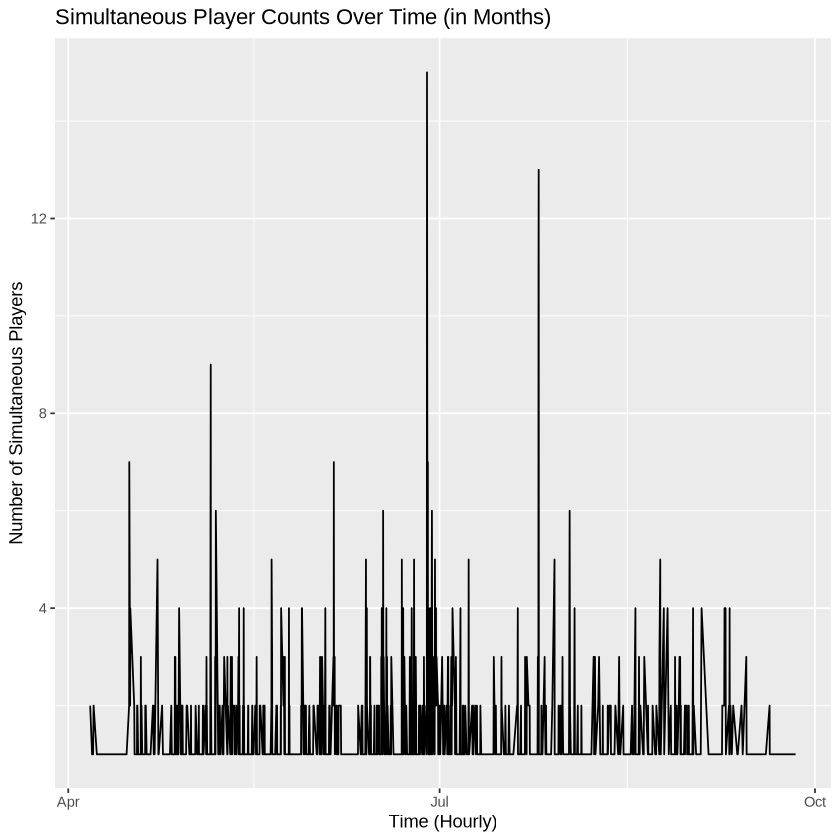

In [4]:
ggplot(time_windows, aes(x = hour, y = simultaneous_players)) +
  geom_line() +
  labs(
    title = "Simultaneous Player Counts Over Time (in Months)",
    x = "Time (Hourly)",
    y = "Number of Simultaneous Players"
  )


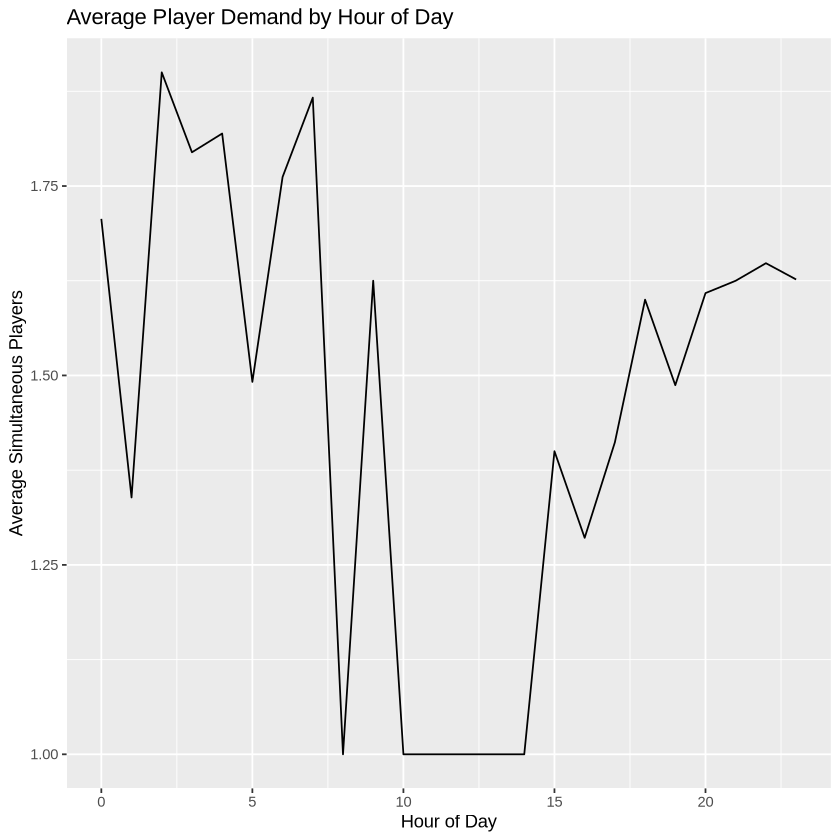

In [5]:
#add hour of day 
time_windows <- time_windows %>%
  mutate(hour_of_day = as.integer(format(hour, "%H")))

#calculte simul players during time of day (24 hr format)
avg_demand_by_hour <- time_windows %>%
  group_by(hour_of_day) %>%
  summarise(avg_players = mean(simultaneous_players, na.rm = TRUE))

# avg simul player vs hour of day
ggplot(avg_demand_by_hour, aes(x = hour_of_day, y = avg_players)) +
  geom_line() +
  labs(
    title = "Average Player Demand by Hour of Day",
    x = "Hour of Day",
    y = "Average Simultaneous Players"
  )



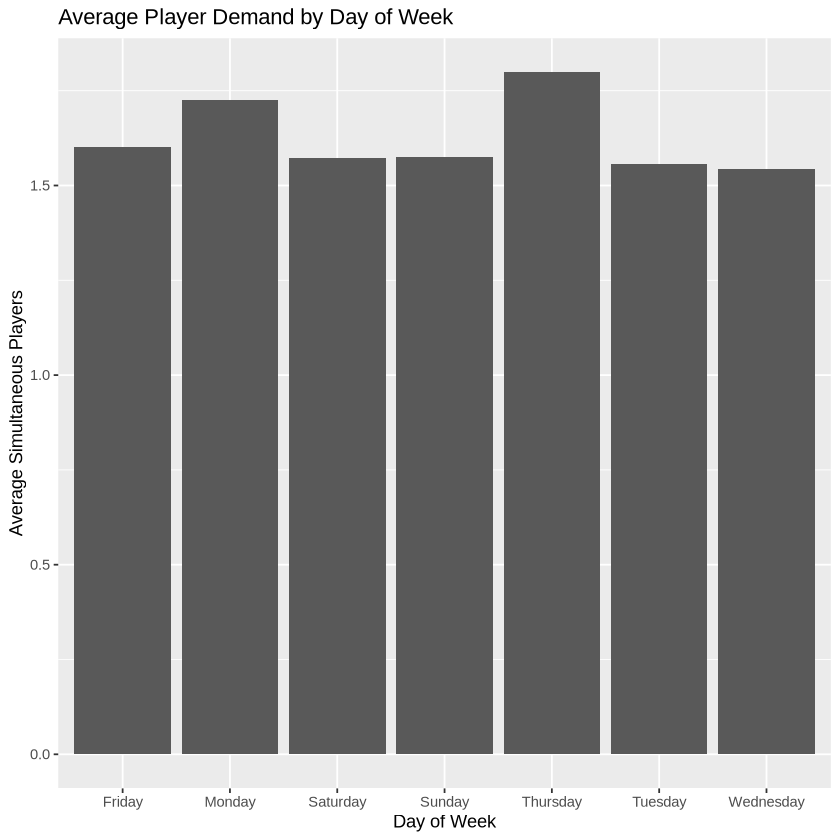

In [6]:
#add day of week
time_windows <- time_windows %>%
  mutate(day_of_week = weekdays(hour))
# count avg player simultaneous count
avg_demand_by_day <- time_windows %>%
  group_by(day_of_week) %>%
  summarise(avg_players = mean(simultaneous_players, na.rm = TRUE))

#plot average simul players vs day of week
ggplot(avg_demand_by_day, aes(x = day_of_week, y = avg_players)) +
  geom_bar(stat = "identity") +
  labs(
    title = "Average Player Demand by Day of Week",
    x = "Day of Week",
    y = "Average Simultaneous Players"
  )


## Analysis of EDA

The exploratory data analysis (EDA) revealed that the non-linear patterns and odd spikes in the number of concurrent players make linear regression unsuitable for modeling the data. Particularly, the regression model's low R-squared value and negligible coefficients imply that the predictors—like the time of day and whether it's a weekend or a weekday—do not adequately capture the complexity of the demand for simultaneous players.

Investigating K-Nearest Neighbors (K-NN) and clustering techniques would be the next best course of action in light of these difficulties. These two approaches work well for managing non-linear data and finding patterns in datasets with a lot of variation.


## Methods and Plan

Because of the structure of the data, K-means clustering is our main approach for this problem. As seen by the "Simultaneous Player Counts over Time" plot, this approach is perfect for identifying intricate, non-linear patterns in player activity, such as abrupt spikes and peaks in player counts that are visible across the dataset. K-means clustering uses characteristics like the time of day and whether it is a weekend or a weekday to group together comparable time slots. This enables us to predict when concurrent player licenses will be necessary and locate times with comparable player demand.

Instead of assuming a strict linear relationship, K-means clustering allows us to capture a range of player behavior across different times and days. By clustering the data, we can identify recurring patterns of high or low demand that are not limited to linear trends. This method is particularly useful for understanding the variations in player counts and predicting when server capacity should be optimized for peak demand.

To evaluate the performance of the clustering model, we will analyze cluster purity and assess how well the identified clusters align with the expected player demand patterns. The data will be split into a 70% training set and a 30% test set, allowing us to test how well the clustering model generalizes to new, unseen time periods. This approach offers a flexible and scalable solution for predicting peak demand times and managing server capacity accordingly.

hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12


hashedEmail,x
<chr>,<dbl>
0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,53.00000
060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,30.00000
0ce7bfa910d47fc91f21a7b3acd8f33bde6db57912ce0290fa0437ce0b97f387,11.00000
0d4d71be33e2bc7266ee4983002bd930f69d304288a8663529c875f40f1750f3,32.15385
0d70dd9cac34d646c810b1846fe6a85b9e288a76f5dcab9c1ff1a0e7ca200b3a,35.00000
11006065e9412650e99eea4a4aaaf0399bc338006f85e80cc82d18b49f0e2aa4,10.00000


Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


hour,simultaneous_players
<dttm>,<int>
2024-04-06 09:00:00,2
2024-04-06 20:00:00,1
2024-04-06 22:00:00,1
2024-04-07 00:00:00,1
2024-04-07 02:00:00,1
2024-04-07 05:00:00,2


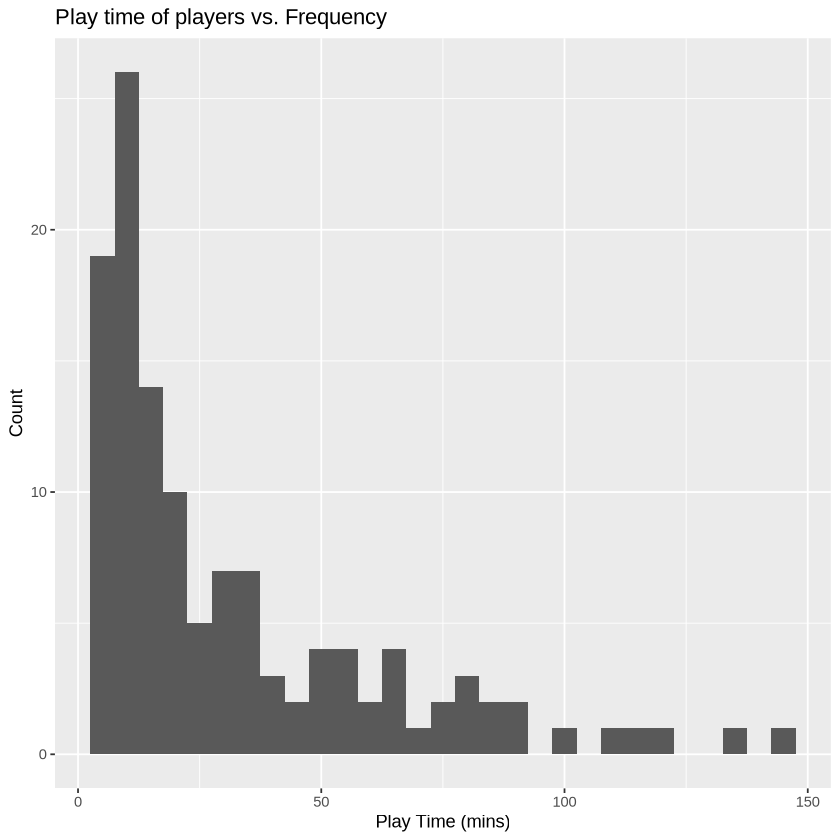

In [18]:
head(sessions)
# Calculating the time of sessions by hashedEmail to see the total play-time for a given email
time_played <- sessions |>
  mutate(start_time = dmy_hm(start_time),end_time = dmy_hm(end_time) )|>
  mutate(time_played = as.numeric(difftime(end_time, start_time, units = "mins")))|>
  group_by(hashedEmail)|>
  summarize(x=mean(time_played))
head(time_played)
time_played_plot<-time_played|>
    ggplot(aes(x=x))+
    geom_histogram(binwidth=5) +
    labs( x= "Play Time (mins)",
         y = "Count",
         title = "Play time of players vs. Frequency")
time_played_plot

# Aggregate the data by hour to calculate the number of simultaneous players
time_windows_agg <- time_windows %>%
  group_by(hour) %>%
  summarise(simultaneous_players = n())

# Convert the time back to datetime format for easier analysis and plotting
time_windows_agg <- time_windows_agg %>%
  mutate(hour = as.POSIXct(hour, format = "%Y-%m-%d %H:%M:%S"))

# Check the aggregated data
head(time_windows_agg)

The histogram shows a pronounced right-skewed distribution. This pattern indicates that the majority of players exhibit relatively short average playtimes, while the frequency of players steadily diminishes as the duration of playtime extends. In other words, there's a concentration of players with brief gaming sessions, and progressively fewer individuals engage in longer periods of gameplay.

In [8]:
players_tidy<-players|>
    select(experience:age)
nrow(players_tidy)
head(players_tidy)

[1] 196

experience,subscribe,hashedEmail,played_hours,name,gender,age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


In [9]:
df_combined <- merge(players_tidy, time_played, by = "hashedEmail")
head(df_combined)

,hashedEmail,experience,subscribe,played_hours,name,gender,age,x
,<chr>,<chr>,<lgl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
1,0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,Regular,TRUE,1.5,Isaac,Male,20,53.00000
2,060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,Pro,FALSE,0.4,Lyra,Male,21,30.00000
3,0ce7bfa910d47fc91f21a7b3acd8f33bde6db57912ce0290fa0437ce0b97f387,Beginner,TRUE,0.1,Osiris,Male,17,11.00000
4,0d4d71be33e2bc7266ee4983002bd930f69d304288a8663529c875f40f1750f3,Regular,TRUE,5.6,Winslow,Male,17,32.15385
5,0d70dd9cac34d646c810b1846fe6a85b9e288a76f5dcab9c1ff1a0e7ca200b3a,Pro,TRUE,1.0,Knox,Male,17,35.00000
6,11006065e9412650e99eea4a4aaaf0399bc338006f85e80cc82d18b49f0e2aa4,Veteran,FALSE,0.1,Callum,Male,19,10.00000


Using this df, we can now perform some analysis, such as clustering.

weekend_weekday,avg_plyrs
<chr>,<dbl>
Weekday,1.642628
Weekend,1.574074


hour,simultaneous_players,hour_of_day,weekend_weekday,day_of_week
<dttm>,<int>,<int>,<chr>,<chr>
2024-04-06 09:00:00,2,9,Weekend,Saturday
2024-04-06 20:00:00,1,20,Weekend,Saturday
2024-04-06 22:00:00,1,22,Weekend,Saturday
2024-04-07 00:00:00,1,0,Weekend,Sunday
2024-04-07 02:00:00,1,2,Weekend,Sunday
2024-04-07 05:00:00,2,5,Weekend,Sunday


hour_of_day_scaled,weekend_weekday_binary,simultaneous_players
"<dbl[,1]>",<dbl>,<int>
-0.1808995,1,2
1.1218767,1,1
1.3587452,1,1
-1.2468073,1,1
-1.0099389,1,1
-0.6546363,1,2


hour,simultaneous_players,hour_of_day,weekend_weekday,day_of_week,hour_of_day_scaled,weekend_weekday_binary,cluster
<dttm>,<int>,<int>,<chr>,<chr>,"<dbl[,1]>",<dbl>,<int>
2024-04-06 09:00:00,2,9,Weekend,Saturday,-0.1808995,1,2
2024-04-06 20:00:00,1,20,Weekend,Saturday,1.1218767,1,1
2024-04-06 22:00:00,1,22,Weekend,Saturday,1.3587452,1,1
2024-04-07 00:00:00,1,0,Weekend,Sunday,-1.2468073,1,2
2024-04-07 02:00:00,1,2,Weekend,Sunday,-1.0099389,1,2
2024-04-07 05:00:00,2,5,Weekend,Sunday,-0.6546363,1,2


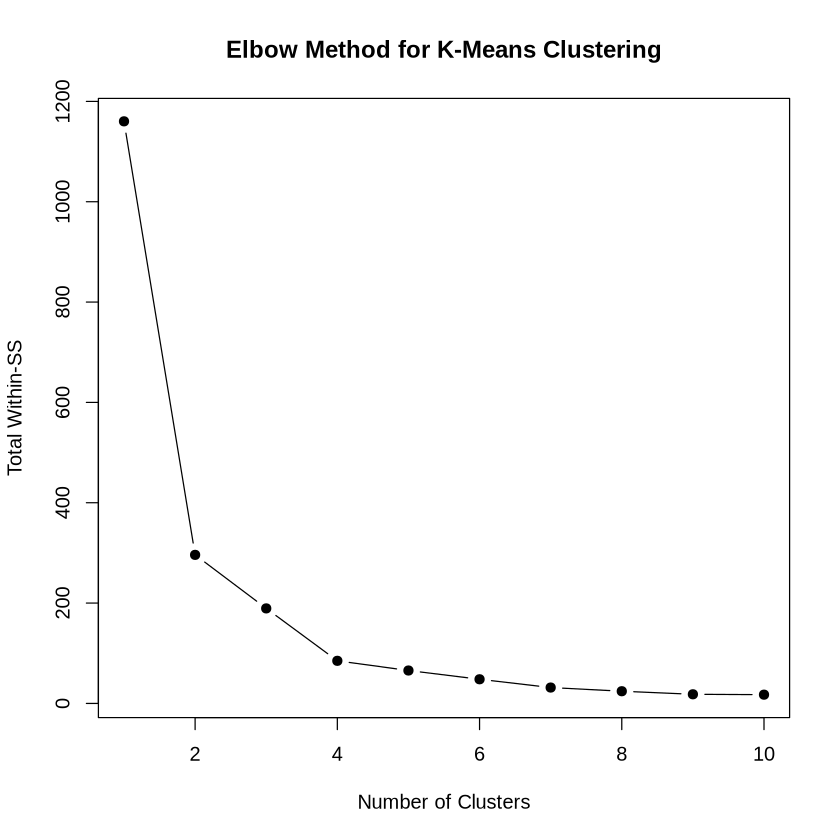

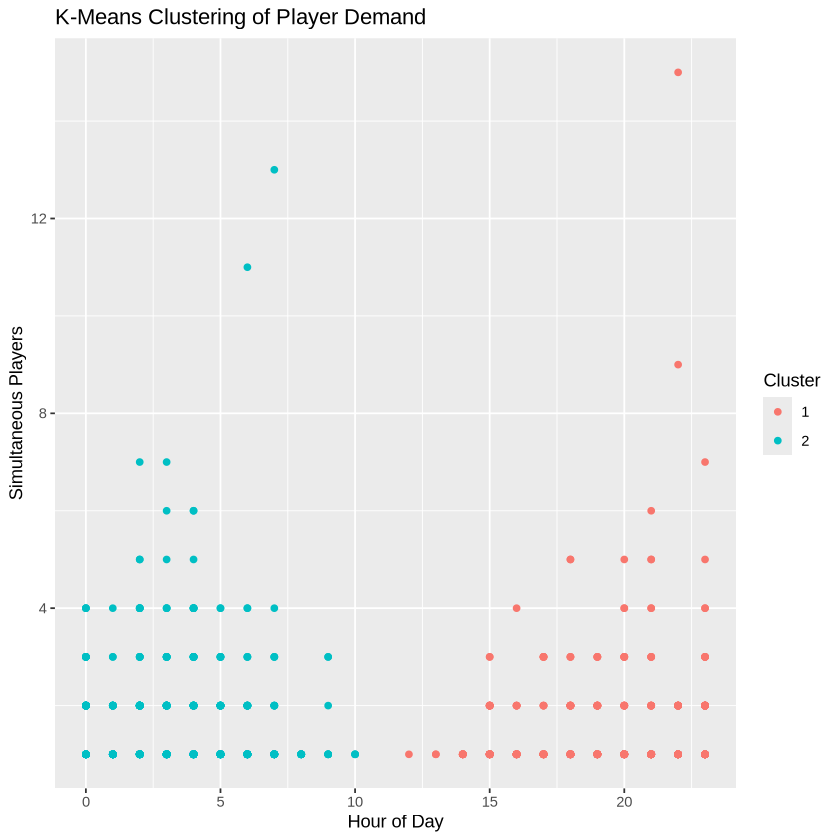

In [19]:
time_windows <- merged_data %>%
  mutate(
    hour_of_day = as.integer(format(start_datetime, "%H")),  # Hour of the day (0-23)
    day_of_week = weekdays(start_datetime),  # Day of the week
    weekend_weekday = ifelse(weekdays(start_datetime) %in% c("Saturday", "Sunday"), "Weekend", "Weekday"),  # Weekend/Weekday binary
    hour = format(start_datetime, "%Y-%m-%d %H:00:00")  # Standardize the time to hourly
  )

time_windows_agg <- time_windows %>%
  group_by(hour) %>%
  summarise(
    simultaneous_players = n(),
    hour_of_day = first(hour_of_day),  # Round the hours
    weekend_weekday = first(weekend_weekday),  # Retain the first value of weekend_weekday for each group
    day_of_week = first(day_of_week)
  )


time_windows_plot<-time_windows_agg|>
    group_by(weekend_weekday)|>
    summarize(avg_plyrs = mean(simultaneous_players))
head(time_windows_plot)

# Convert back for plotting
time_windows_agg <- time_windows_agg %>%
  mutate(hour = as.POSIXct(hour, format = "%Y-%m-%d %H:%M:%S"))

# Check the agg data
head(time_windows_agg)

# Scale the continuous features (hour_of_day)
time_windows_agg <- time_windows_agg %>%
  mutate(hour_of_day_scaled = scale(hour_of_day))


time_windows_agg <- time_windows_agg %>%
  mutate(weekend_weekday_binary = ifelse(weekend_weekday == "Weekend", 1, 0)) # 0 for Weekday, 1 for Weekend


clustering_data <- time_windows_agg %>%
  select(hour_of_day_scaled, weekend_weekday_binary, simultaneous_players)
clustering_data_scaled <- clustering_data %>%
  mutate(across(where(is.numeric), scale))  # Standardizing all numeric columns
clustering_data_scaled <- clustering_data %>%
  mutate(across(where(is.numeric), ~ (.-min(.)) / (max(.) - min(.))))


# Check the data for clustering
head(clustering_data)

# Perform K-means clustering using different values of k to find the optimal number of clusters
set.seed(123)  # Set seed for reproducibility

# Try different values of k
wss <- numeric(10)
for (k in 1:10) {
  kmeans_model <- kmeans(clustering_data[, c("hour_of_day_scaled", "weekend_weekday_binary")], centers = k, nstart = 25)
  wss[k] <- kmeans_model$tot.withinss
}

# Plot the WSS (Within-cluster Sum of Squares) to identify the "elbow"
plot(1:10, wss, type = "b", pch = 19, xlab = "Number of Clusters", ylab = "Total Within-SS", main = "Elbow Method for K-Means Clustering")

# Fit the K-means model with the optimal number of clusters (let's assume k=2)
kmeans_model <- kmeans(clustering_data[, c("hour_of_day_scaled", "weekend_weekday_binary")], centers = 2, nstart = 25)

# Add the cluster assignments to the data
time_windows_agg$cluster <- kmeans_model$cluster

# Check the clustering results
head(time_windows_agg)

# Visualizing the clusters
ggplot(time_windows_agg, aes(x = hour_of_day, y = simultaneous_players, color = factor(cluster))) +
  geom_point() +
  labs(
    title = "K-Means Clustering of Player Demand",
    x = "Hour of Day",
    y = "Simultaneous Players",
    color = "Cluster"
  ) 


## Discussions
One drawback of clustering is that, since a player may appear in more than one cluster, it might not consider how they behaved over various time frames. To counteract this, we will pay more attention to the general demand trends in each cluster than to specific player sessions. Furthermore, it is essential to choose the ideal number of clusters (k), and we will employ techniques like the elbow approach to get the ideal value for k. In our case, the best k value seems to be 2, as the "elbow" occurred at k = 2, where any further increase in k did not lead to a significant decrease in Total Within SS. This also makes sense visually, as the plot above shows there are 2 distinct clusters of dots, even without the colouring.

First, we looked at whether there's a difference in the player base during the weekdays and the weekends. The data is grouped by whether it was a weekday or a weekend, and the average number of players was calculated. Surprisingly, it was found that there was no significant difference. In fact, there were slightly more people playing during weekdays than weekends. This finding suggests that the fact that it's the weekend doesn't necessarily mean there will be more players.

From the scatterplot above showing the clusters by colour, we see that there are two distinct clusters at the beginning and the end of the day. The two clusters are from time 0:00 to 9:00, and from time 15:00 to 24:00. This is quite unusual to us because one would expect the most players to be during the day (i.e., from 8:00 to 22:00). Our findings revealed that you cannot simply assume people are getting on the server at the expected peak hours, but analysis and visualization is needed to confirm our theories. A question this leads to is why do most people get on at this unexpected time of day. Are there any confounding factors that may lead to this result (perhaps people who play a lot of video games tend to have an unusual sleep schedule)?

Looking at the histogram with the total play time by hashedEmail, because the median is low, we know that a big proportion of the players have very low playtime. This finding may skew the clustering scatterplot, depending on whether the research group want to target more players or more playtime. The fact remains that most of the player base has low play times, and the CS group should try different methods of retaining a player for a bit longer, like making a special event during the aforementioned "peak hours".

Our scatterplot above also revealed the "50 player limit" may be a lot over than what is needed at this time because the total concurrent players never exceeded 20. If it costs significantly more to have a bigger server, it might be good to decrease the player limit.